# SARIMA forcsating into random forest - Team MACRO

### Imports

In [87]:
#general
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

#plotting
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#SARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#Scikit learn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#Scikit learn in case of extrapolation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
### forecast
Data_forecasts = []

# TEMPERATURE

### Setting up data - Temperature

In [151]:
#array of dataframes
fullData = []
var_names = []

In [152]:
temp_tempdf = pd.read_csv("MonthlyTemp.csv", skiprows=4)
temperature = temp_tempdf.to_numpy()

temp_ngData = temperature
temp_rows, temp_cols = temp_ngData.shape
temp_ngData2 = [0 for i in range(temp_rows)]


for j in range(len(temp_ngData)):
    temp = temp_ngData[j][0]
    temp = str(temp)
    month = int(float(temp[4:]))
    year = int(temp[:4])
    ready4date = str(month) + "/1/" + str(year)
    dates = datetime.strptime(ready4date, "%m/%d/%Y")
    temp_ngData2[j] = ([dates, temp_ngData[j][1]])
    
temp_ngData2 = np.array(temp_ngData2, dtype=object)

temperaturedf = pd.DataFrame(temp_ngData2, columns=["Date", "Temp"])

temperaturedf["Temp"] = pd.to_numeric(temperaturedf["Temp"])

temperaturedf = temperaturedf.resample('D', on='Date').mean()

temperaturedf = temperaturedf.interpolate(method='linear', axis=0)

fullData.append(temperaturedf)
var_names.append("Temp")


### Visualization of data - Temperature

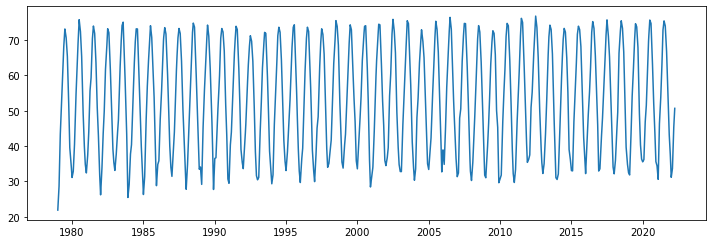

In [153]:
plt.plot(temperaturedf)
plt.show()

### selecting data - weekly data for certain years - Temperature

In [154]:
data_start = datetime(2010, 1, 1)
data_end = datetime(2020, 1, 1)
temperaturedf = temperaturedf[data_start:data_end]
weekly_temp = temperaturedf.resample("W").mean()

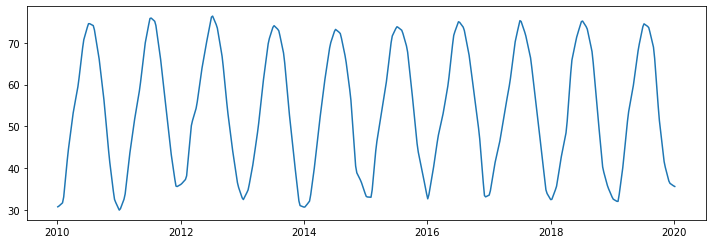

In [155]:
plt.plot(weekly_temp)
plt.show()

### Differencing data to find "d" - Temperature

In [156]:
print("P-val = " , adfuller(weekly_temp)[1])

P-val =  1.3527093309849536e-17


### ACF and PACF - Temperature

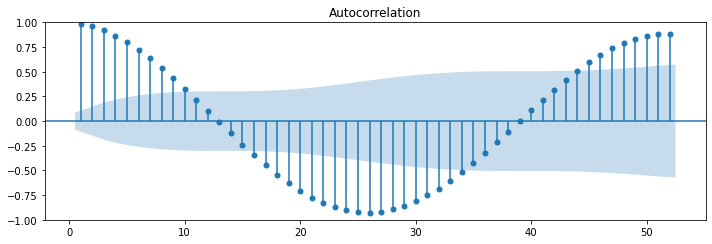

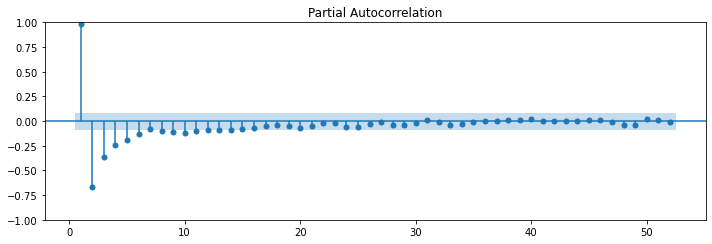

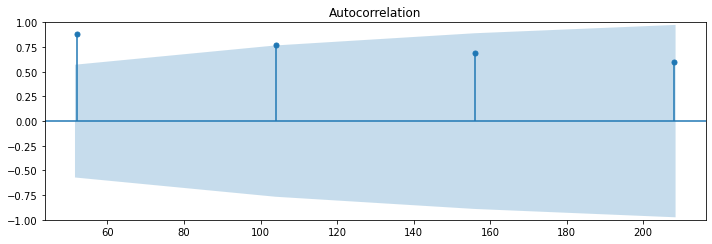

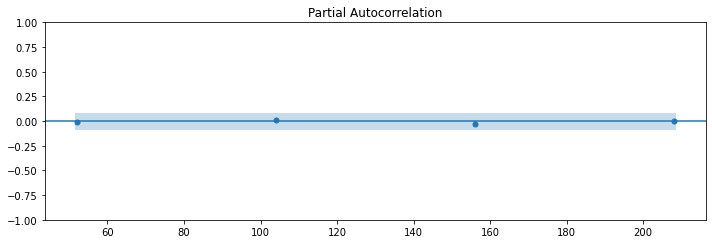

In [157]:
s_lag = [52, 104, 156, 208]

acf = plot_acf(weekly_temp, lags = 52, zero=False)
pacf = plot_pacf(weekly_temp, lags = 52, method='ywm', zero=False)

s_acf = plot_acf(weekly_temp, lags = s_lag)
s_pacf = plot_pacf(weekly_temp, lags = s_lag, method='ywm')

### Train/Test split - Temperature

In [158]:
train_end = datetime(2019, 1, 1)

train_data = weekly_temp[:train_end]
test_data = weekly_temp[train_end:]

### Setting up orders  - Temperature

In [159]:
my_order = (5, 1, 2) # already stationary? - not need lag?
my_seasonal_order = (2, 1, 2, 52)

### fitting model - Temperature

In [160]:
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

In [161]:
model_fit = model.fit()
pred = model_fit.predict()

/Users/arjunsohur/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27933D-01    |proj g|=  1.55390D+00

At iterate    5    f=  2.61174D-01    |proj g|=  3.04528D-01

At iterate   10    f=  2.46222D-01    |proj g|=  1.22128D-01

At iterate   15    f=  2.39863D-01    |proj g|=  6.74354D-02

At iterate   20    f=  2.39110D-01    |proj g|=  8.94476D-03

At iterate   25    f=  2.38735D-01    |proj g|=  2.03047D-02

At iterate   30    f=  2.37954D-01    |proj g|=  7.32677D-03

At iterate   35    f=  2.35739D-01    |proj g|=  6.65471D-02

At iterate   40    f=  2.32587D-01    |proj g|=  5.62344D-02

At iterate   45    f=  2.31374D-01    |proj g|=  1.28717D-02

At iterate   50    f=  2.29164D-01    |proj g|=  5.14086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/arjunsohur/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Temp   No. Observations:                  470
Model:             SARIMAX(5, 1, 2)x(2, 1, 2, 52)   Log Likelihood                -107.707
Date:                            Fri, 19 Aug 2022   AIC                            239.414
Time:                                    15:03:20   BIC                            287.811
Sample:                                01-03-2010   HQIC                           258.549
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0315      0.055     18.799      0.000       0.924       1.139
ar.L2          0.5833      0.074   

### Visualizing prediction error - Temperature

In [162]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.DataFrame(predictions, index=test_data.index)
residuals = predictions.iloc[:,0].subtract(test_data.iloc[:,0])

Text(0, 0.5, 'Error')

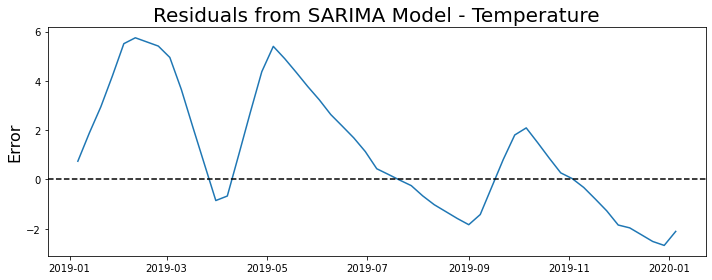

In [163]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model - Temperature', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Visualizing prediction - Temperature

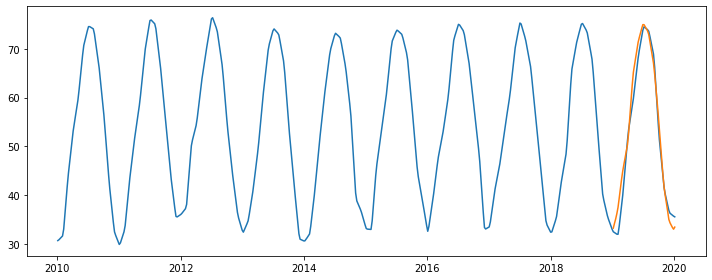

In [164]:
plt.figure(figsize=(10,4))

plt.plot(weekly_temp)
plt.plot(predictions)
#plt.plot(pred)

# WITHDRAWLS

In [61]:
#array of dataframes
fullData = []
var_names = []

### Setting up data - Withdrawls

In [62]:
#array of dataframes
withd = pd.read_csv("Withdrawls.csv", skiprows=105, nrows=505, usecols=[0, 1])

# to np array
withd = withd.to_numpy()

# to datetime
for j in range(len(withd)):
    withd[j][0] = datetime.strptime(withd[j][0], '%b-%Y')
    
# getting the first two value
ready4df = withd[:, [0, 1]]

# converting to dataframe
withddf = pd.DataFrame(ready4df, columns=["Date", "Withdrawal"])

# interpolating data to fill dates
withddf["Withdrawal"] = pd.to_numeric(withddf["Withdrawal"])
withddf = withddf.resample('D', on='Date').mean()
withddf = withddf.interpolate(method='linear', axis=0)

# appending to whole
fullData.append(withddf)
var_names.append("Withdrawls")

### Visualization of data - Withdrawls

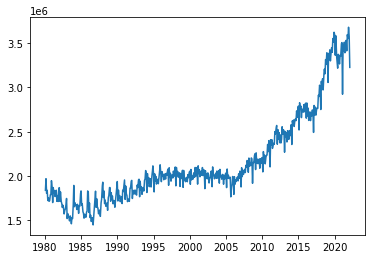

In [63]:
plt.plot(withddf)
plt.show()

### Selecting data - weekly data for certain years - Withdrawls

In [64]:
data_start = datetime(2010, 1, 1)
data_end = datetime(2020, 1, 1)
withddf = withddf[data_start:data_end]
weekly_withddf = withddf.resample("W").mean()

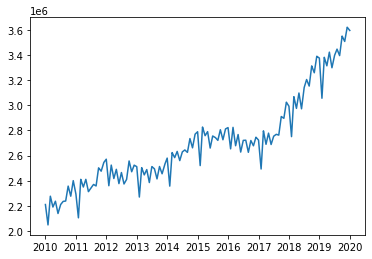

In [65]:
plt.plot(withddf)
plt.show()

### Differencing data to find "d" - Withdrawls

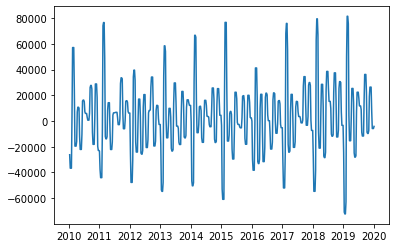

P-val =  3.5034480783387733e-06


In [66]:
diff1_weekly_withd = weekly_withddf.diff(1)[1:]

plt.plot(diff1_weekly_withd)
plt.show()

print("P-val = " , adfuller(diff1_weekly_withd)[1])

### ACF and PACF - Withdrawls

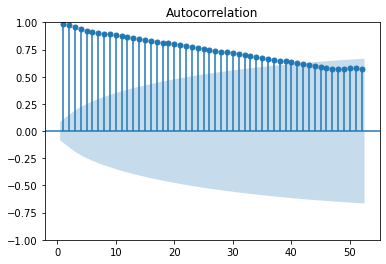

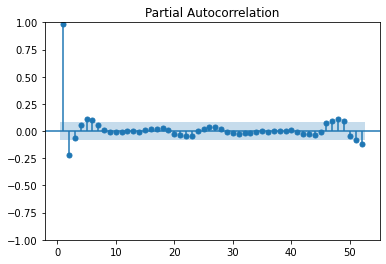

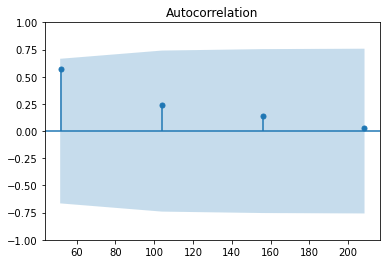

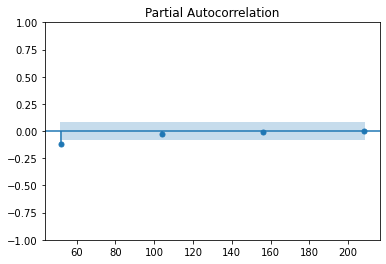

In [67]:
s_lag = [52, 104, 156, 208]

acf = plot_acf(weekly_withddf, lags = 52, zero=False)
pacf = plot_pacf(weekly_withddf, lags = 52, method='ywm', zero=False)

s_acf = plot_acf(weekly_withddf, lags = s_lag)
s_pacf = plot_pacf(weekly_withddf, lags = s_lag, method='ywm')

### Train/Test split - Withdrawls

In [68]:
train_end = datetime(2019, 6, 1)

train_data = weekly_withddf[:train_end]
test_data = weekly_withddf[train_end:]

### Setting up orders  - Withdrawls

In [69]:
my_order = (1, 1, 2)
my_seasonal_order = (1, 1, 2, 52)

### fitting model - Withdrawls

In [70]:
model = SARIMAX(train_data, order = my_order, seasonal_order=my_seasonal_order)

model_fit = model.fit()
pred = model_fit.predict()

print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34044D+02    |proj g|=  3.51358D+02

At iterate    5    f=  1.17404D+02    |proj g|=  2.81575D+01

At iterate   10    f=  9.96529D+00    |proj g|=  2.45027D+00

At iterate   15    f=  9.91698D+00    |proj g|=  1.57234D-01

At iterate   20    f=  9.91683D+00    |proj g|=  1.78580D-02

At iterate   25    f=  9.91651D+00    |proj g|=  1.13082D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     47      1     0     0   

### Visualizing prediction error - Withdrawls

Text(0, 0.5, 'Error')

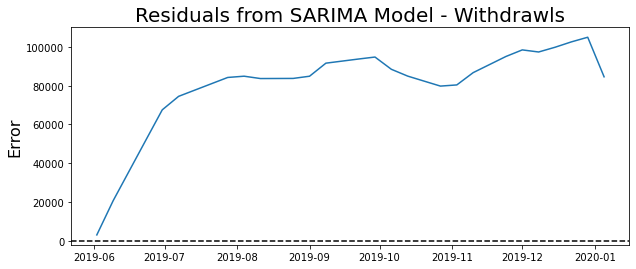

In [71]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.DataFrame(predictions, index=test_data.index)
residuals = predictions.iloc[:,0].subtract(test_data.iloc[:,0])

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model - Withdrawls', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Visualizing prediction - Withdrawls

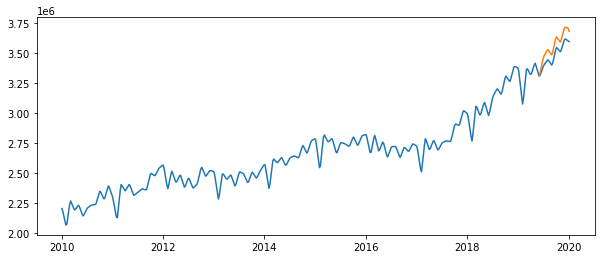

In [72]:
plt.figure(figsize=(10,4))

plt.plot(weekly_withddf)
plt.plot(predictions)
#plt.plot(pred)

# STORAGE

In [73]:
#array of dataframes
fullData = []
var_names = []

### Setting up data - Storage

In [74]:
# getting file locally
stordf1 = pd.read_csv("CSVngStorage.csv", skiprows=2)

# to np array
stor = stordf1.to_numpy()

# to datetime
for j in range(len(stor)):
        stor[j][0] = datetime.strptime(stor[j][0], "%d-%b-%y")
        
# getting the first two value
ready4df = stor[:, [0, 1]]

# converting to dataframe
stordf = pd.DataFrame(ready4df, columns=["Date", "Storage"])

# interpolating data to fill dates
stordf["Storage"] = pd.to_numeric(stordf["Storage"])
stordf = stordf.resample('D', on='Date').mean()
stordf = stordf.interpolate(method='linear', axis=0)

# appending to whole
fullData.append(stordf)
var_names.append("Storage")

### Visualization of data - Storage

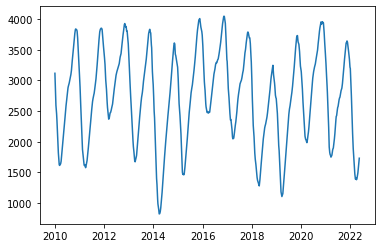

In [75]:
plt.plot(stordf)
plt.show()

### Selecting data - weekly data for certain years - Storage

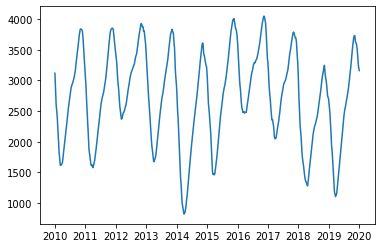

In [76]:
data_start = datetime(2010, 1, 1)
data_end = datetime(2020, 1, 1)

stordf = stordf[data_start:data_end]
weekly_stordf =stordf.resample("W").mean()

plt.plot(stordf)
plt.show()

### Differencing data to find "d" - Storage

In [77]:
#diff1_weekly_stordf = weekly_stordf.diff(1)[1:]

#plt.plot(diff1_weekly_stordf)
#plt.show()

print("P-val = " , adfuller(weekly_stordf)[1])

P-val =  4.694330312647266e-06


### ACF and PACF - Storage

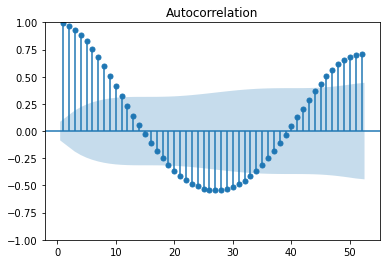

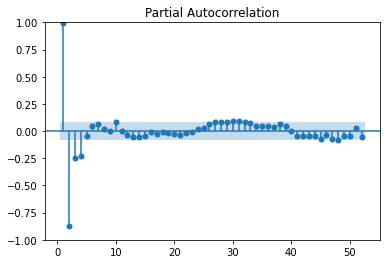

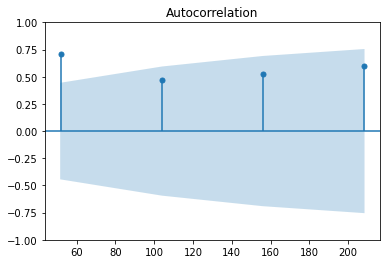

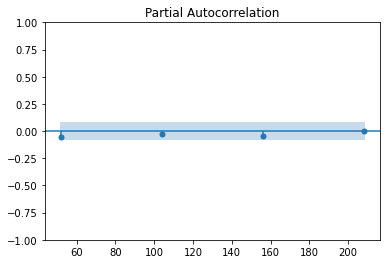

In [78]:
s_lag = [52, 104, 156, 208]

acf = plot_acf(weekly_stordf, lags = 52, zero=False)
pacf = plot_pacf(weekly_stordf, lags = 52, method='ywm', zero=False)

s_acf = plot_acf(weekly_stordf, lags = s_lag)
s_pacf = plot_pacf(weekly_stordf, lags = s_lag, method='ywm')

### Train/Test split - Storage

In [79]:
train_end = datetime(2019, 6, 1)

train_data = weekly_stordf[:train_end]
test_data = weekly_stordf[train_end:]

### Setting up orders  - Storage

In [80]:
my_order = (1, 0, 5)
my_seasonal_order = (1, 1, 2, 52)

### fitting model - Storage

In [81]:
model = SARIMAX(train_data, order = my_order, seasonal_order=my_seasonal_order)

In [82]:
model_fit = model.fit()
pred = model_fit.predict()

/Users/arjunsohur/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69206D+00    |proj g|=  4.74934D-01


 This problem is unconstrained.



At iterate    5    f=  4.49200D+00    |proj g|=  8.67871D-03

At iterate   10    f=  4.46588D+00    |proj g|=  7.93160D-02

At iterate   15    f=  4.44597D+00    |proj g|=  1.00429D-02

At iterate   20    f=  4.43343D+00    |proj g|=  7.55112D-03

At iterate   25    f=  4.43292D+00    |proj g|=  4.00411D-03

At iterate   30    f=  4.43204D+00    |proj g|=  3.31823D-03

At iterate   35    f=  4.43196D+00    |proj g|=  1.85746D-03

At iterate   40    f=  4.43066D+00    |proj g|=  2.82037D-02

At iterate   45    f=  4.42982D+00    |proj g|=  1.42789D-03


/Users/arjunsohur/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.42978D+00    |proj g|=  1.25965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   1.260D-03   4.430D+00
  F =   4.4297808734411621     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [83]:
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                 Storage   No. Observations:                  491
Model:             SARIMAX(1, 0, 5)x(1, 1, [1, 2], 52)   Log Likelihood               -2175.022
Date:                                 Fri, 19 Aug 2022   AIC                           4370.045
Time:                                         15:09:06   BIC                           4410.890
Sample:                                     01-03-2010   HQIC                          4386.160
                                          - 05-26-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9746      0.003    375.482      0.000       0.970       0

### Visualizing prediction error - Storage

In [84]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.DataFrame(predictions, index=test_data.index)
residuals = predictions.iloc[:,0].subtract(test_data.iloc[:,0])

Text(0, 0.5, 'Error')

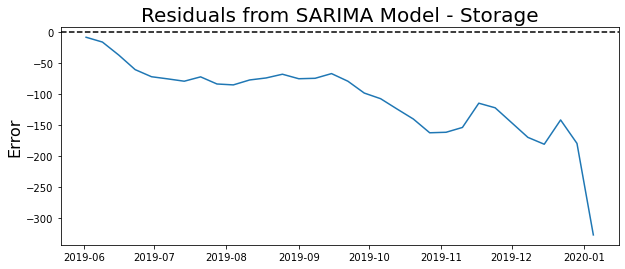

In [85]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model - Storage', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Visualizing prediction - Storage

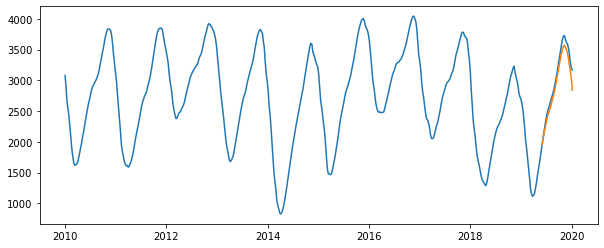

In [86]:
plt.figure(figsize=(10,4))

plt.plot(weekly_stordf)
plt.plot(predictions)
#plt.plot(pred)

# Random Forrest Regression with polynomial Regression Backup

### Collecting local data 
This is doing the same thing as above - maybe streamline data collection process?

In [131]:
#array of dataframes
fullData = []
var_names = []

Price

In [132]:
# getting file locally
price = pd.read_csv("Price.csv", skiprows=4)

# to np array
data = price.to_numpy(np.dtype(datetime, float))

# setting column names
Pricedf = pd.DataFrame(data, columns=["Date", "Price"])

# putting columns to their respective type
Pricedf["Date"] = pd.to_datetime(Pricedf["Date"])
Pricedf["Price"] = pd.to_numeric(Pricedf["Price"])

# interpolating data to fill dates
Pricedf = Pricedf.resample('D', on='Date').mean()
Pricedf = Pricedf.interpolate(method='linear', axis=0)

# appending to whole
fullData.append(Pricedf)

Withdrawls

In [133]:
# getting file locally
withd = pd.read_csv("Withdrawls.csv", skiprows=105, nrows=505, usecols=[0, 1])

# to np array
withd = withd.to_numpy()

# to datetime
for j in range(len(withd)):
    withd[j][0] = datetime.strptime(withd[j][0], '%b-%Y')
    
# getting the first two value
ready4df = withd[:, [0, 1]]

# converting to dataframe
withddf = pd.DataFrame(ready4df, columns=["Date", "Withdrawal"])

# interpolating data to fill dates
withddf["Withdrawal"] = pd.to_numeric(withddf["Withdrawal"])
withddf = withddf.resample('D', on='Date').mean()
withddf = withddf.interpolate(method='linear', axis=0)

# appending to whole
fullData.append(withddf)
var_names.append("Withdrawls")

Working storage

In [134]:
# getting file locally
stordf1 = pd.read_csv("CSVngStorage.csv", skiprows=2)

# to np array
stor = stordf1.to_numpy()

# to datetime
for j in range(len(stor)):
        stor[j][0] = datetime.strptime(stor[j][0], "%d-%b-%y")
        
# getting the first two value
ready4df = stor[:, [0, 1]]

# converting to dataframe
stordf = pd.DataFrame(ready4df, columns=["Date", "Storage"])

# interpolating data to fill dates
stordf["Storage"] = pd.to_numeric(stordf["Storage"])
stordf = stordf.resample('D', on='Date').mean()
stordf = stordf.interpolate(method='linear', axis=0)

# appending to whole
fullData.append(stordf)
var_names.append("Storage")

Temperature

In [135]:
temp_tempdf = pd.read_csv("MonthlyTemp.csv", skiprows=4)
temperature = temp_tempdf.to_numpy()

temp_ngData = temperature
temp_rows, temp_cols = temp_ngData.shape
temp_ngData2 = [0 for i in range(temp_rows)]

for j in range(len(temp_ngData)):
    temp = temp_ngData[j][0]
    temp = str(temp)
    month = int(float(temp[4:]))
    year = int(temp[:4])
    ready4date = str(month) + "/1/" + str(year)
    dates = datetime.strptime(ready4date, "%m/%d/%Y")
    temp_ngData2[j] = ([dates, temp_ngData[j][1]])
    
temp_ngData2 = np.array(temp_ngData2, dtype=object)

temperaturedf = pd.DataFrame(temp_ngData2, columns=["Date", "Temp Anomaly"])

temperaturedf["Temperature"] = pd.to_numeric(temperaturedf["Temp Anomaly"])

temperaturedf = temperaturedf.resample('D', on='Date').mean()

temperaturedf = temperaturedf.interpolate(method='linear', axis=0)

fullData.append(temperaturedf)
var_names.append("Temperature")

### concatenation of data
Dates are from 2011-02-01

In [136]:
data = np.array(fullData, dtype=object)
df = pd.concat(data, axis = "columns")
df = df.iloc[11323:14975, ]

In [137]:
train, test = train_test_split(df, test_size = .25, random_state = 0)

### Splitting data into sets

In [139]:
y_train = train.loc[:,"Price"].to_numpy()
x_train = train.loc[:, train.columns != "Price"].to_numpy()
y_test = test.loc[:,"Price"].to_numpy()
x_test = test.loc[:, test.columns != "Price"].to_numpy()

### Setting up model + prediction

In [141]:
model = RandomForestRegressor()

In [142]:
forest = model.fit(x_train, y_train)

In [143]:
prediction = forest.predict(x_test)

In [144]:
### Visualization

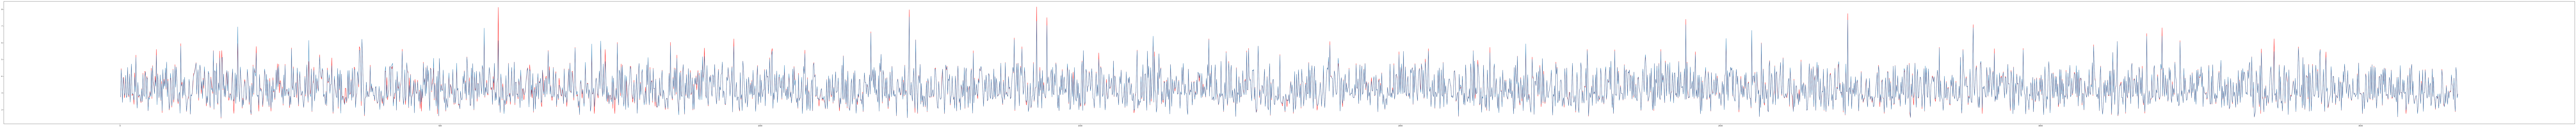

In [145]:
y_total = np.concatenate((y_test, y_train))
x_total = np.concatenate((x_test, x_train))
yt_pred = forest.predict(x_total)

plt.figure(figsize=(200, 10), dpi=80)
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.plot(range(1, len(y_total)+1), y_total, c='red')
plt.plot(range(1, len(yt_pred)+1), yt_pred)

### Error

Notes about error:
    
THIS MODEL IS NOT GOOD AT EXTRAPOLATING DATA.  If an unknown situation arises and any of the data goes beyind the bounds that we have here, the prediction will be off.For that reason, this model isn't an end-all be-all.

I've added a polynomial linear regression to the prediction in case any of the parameters for prediction exceed those of the training set.

Also, the decision parameters that this model creates change with each run, so the errors might change slightly.
The errors should hover around:
MSE - .025
MAE - .08

In [146]:
MSerror = mean_squared_error(prediction, y_test)
MAerror = mean_absolute_error(prediction, y_test)

print("MSE: " , MSerror , "\nMAE: " , MAerror)

MSE:  0.023496647112069457 
MAE:  0.07961480649872205


## Real-world Prediction  with backup linear regression

Enter your values here:

Currently, the values are:
[Withdrawls per month (mmBTU), working storage (mmBTU), temperature (monthly, fahrenheit)]
- All values should be for lower 48 states in US only, as the training data was centered around the lower 48

In [147]:
# ENTER PREDICTION VALUES HERE
Pred_vals = np.array([0,0,0])

Finding means for extrapolation:

If prediciton paramters exceed training set parameters, the program will preform a polynomial linear regression instead of utilizing the random forest data.

Note that random forest is more accurate so, therefore, is more desired.

In [148]:
Change_model = False

for i in range(np.shape(x_train)[1]):
    if Pred_vals[i] >= x_train[:,i].max() or Pred_vals[i] <= x_train[:,i].min():
        Change_model = True

print("Model change: " , Change_model)

Model change:  True


In [149]:
### Executing appropriate model

In [150]:
if not Change_model:
    pred = forest.predict([Pred_vals])
    print("Forest: " , pred)
else:
    poly = PolynomialFeatures(degree = 4, include_bias = False)
    x_poly = poly.fit_transform(x_train)
    ex_model = LinearRegression()
    ex_model.fit(x_poly, y_train)
    y_pred = ex_model.predict(poly.fit_transform(x_test))
    
    MSerror = mean_squared_error(y_pred, y_test)
    MAerror = mean_absolute_error(y_pred, y_test)

    print("Errors of linear regression:\nMSE: " , MSerror , "\nMAE: " , MAerror , "\n")
    
    predict = ex_model.predict(poly.fit_transform([Pred_vals]))
    
    print("Regression: " , predict)

Errors of linear regression:
MSE:  0.3241157139444376 
MAE:  0.4486582908012875 

Regression:  [27.46810509]
